In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 300
rcParams["figure.dpi"] = 300

from celerite import plot_setup
plot_setup.setup(auto=False)

<Container object of 3 artists>

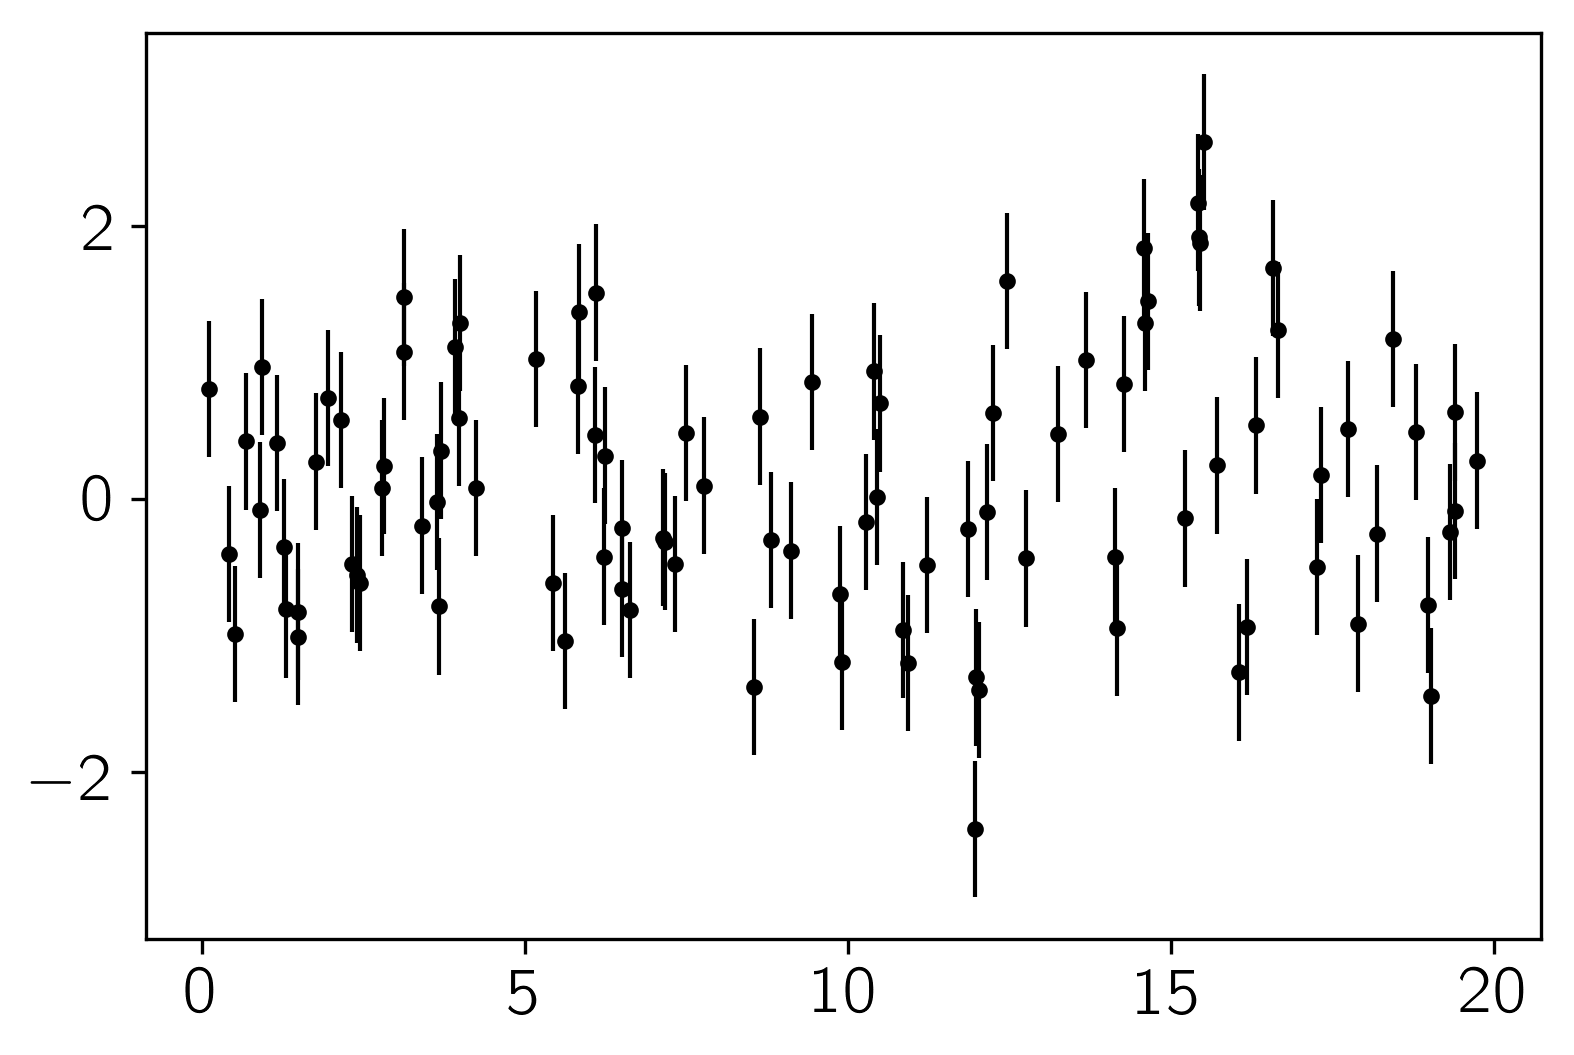

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cho_solve, cho_factor

import celerite
from celerite import terms
from celerite.modeling import Model

class TrueModel(Model):
    parameter_names = ("log_amp", "log_ell", "log_period")

    def get_K(self, x):
        tau = x[:, None] - x[None, :]
        return (
            np.exp(self.log_amp - 0.5 * tau**2 * np.exp(-2.0*self.log_ell)) *
            np.cos(2*np.pi*tau*np.exp(-self.log_period))
        )

    def __call__(self, params, x, y, yerr):
        self.set_parameter_vector(params)
        lp = self.log_prior()
        if not np.isfinite(lp):
            return -np.inf

        K = self.get_K(x)
        K[np.diag_indices_from(K)] += yerr**2
        try:
            factor = cho_factor(K, overwrite_a=True)
        except (np.linalg.LinAlgError, ValueError):
            return -np.inf
        ld = 2.0 * np.sum(np.log(np.diag(factor[0])))
        return -0.5*(np.dot(y, cho_solve(factor, y))+ld) + lp

true_model = TrueModel(log_amp=0.0, log_ell=np.log(5.0), log_period=0.0,
                       bounds=[(-10, 10), (-10, 10), (-10, 10)])

np.random.seed(123)

# Simulate a dataset from the true model
np.random.seed(42)
N = 100
t = np.sort(np.random.uniform(0, 20, N))
yerr = 0.5
K = true_model.get_K(t)
K[np.diag_indices_from(K)] += yerr**2
y = np.random.multivariate_normal(np.zeros(N), K)

# Set up the celerite model that we will use to fit - product of two SHOs
log_Q = 1.0
kernel = terms.SHOTerm(log_S0=np.log(np.var(y))-2*log_Q, log_Q=log_Q,
                       log_omega0=np.log(2*np.pi))
kernel *= terms.SHOTerm(log_S0=0.0, log_omega0=0.0, log_Q=-0.5*np.log(2))
kernel.freeze_parameter("k2:log_S0")
kernel.freeze_parameter("k2:log_Q")
init_params = gp.get_parameter_vector()

gp = celerite.GP(kernel)
gp.compute(t, yerr)

plt.errorbar(t, y, yerr=yerr, fmt=".k", lw=1)

In [11]:
import copy
from scipy.optimize import minimize

def nll(params, gp, y):
    gp.set_parameter_vector(params)
    if not np.isfinite(gp.log_prior()):
        return 1e10
    ll = gp.log_likelihood(y)
    return -ll if np.isfinite(ll) else 1e10

p0 = gp.get_parameter_vector()
soln = minimize(nll, p0, method="L-BFGS-B", args=(gp, y))
gp.set_parameter_vector(soln.x)

kernel.freeze_parameter("k1:log_S0")
p0 = gp.get_parameter_vector()
soln = minimize(nll, p0, method="L-BFGS-B", args=(gp, y))
gp.set_parameter_vector(soln.x)

ml_gp = copy.deepcopy(gp)
ml_gp.log_likelihood(y)

-79.86937205179314

In [12]:
import emcee

# Do the MCMC with the correct model
ndim = 3
nwalkers = 32
coords = true_model.get_parameter_vector() + 1e-4 * np.random.randn(nwalkers,
                                                                    ndim)
true_sampler = emcee.EnsembleSampler(nwalkers, ndim, true_model,
                                     args=(t, y, yerr))
coords, _, _ = true_sampler.run_mcmc(coords, 500)
true_sampler.reset()
coords, _, _ = true_sampler.run_mcmc(coords, 2000);

In [13]:
# Do the MCMC with the (wrong) celerite model
def log_probability(params):
    gp.set_parameter_vector(params)
    
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    
    ll = gp.log_likelihood(y)
    return ll + lp if np.isfinite(ll) else -np.inf

ndim = len(soln.x)
nwalkers = 32
coords = soln.x + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
coords, _, _ = sampler.run_mcmc(coords, 500)
sampler.reset()
coords, _, _ = sampler.run_mcmc(coords, 2000)

In [23]:
p0 = true_model.get_parameter_vector()
%timeit true_model(p0, t, y, yerr)

698 µs ± 77.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [24]:
p0 = gp.get_parameter_vector()
%timeit log_probability(p0)

319 µs ± 53.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


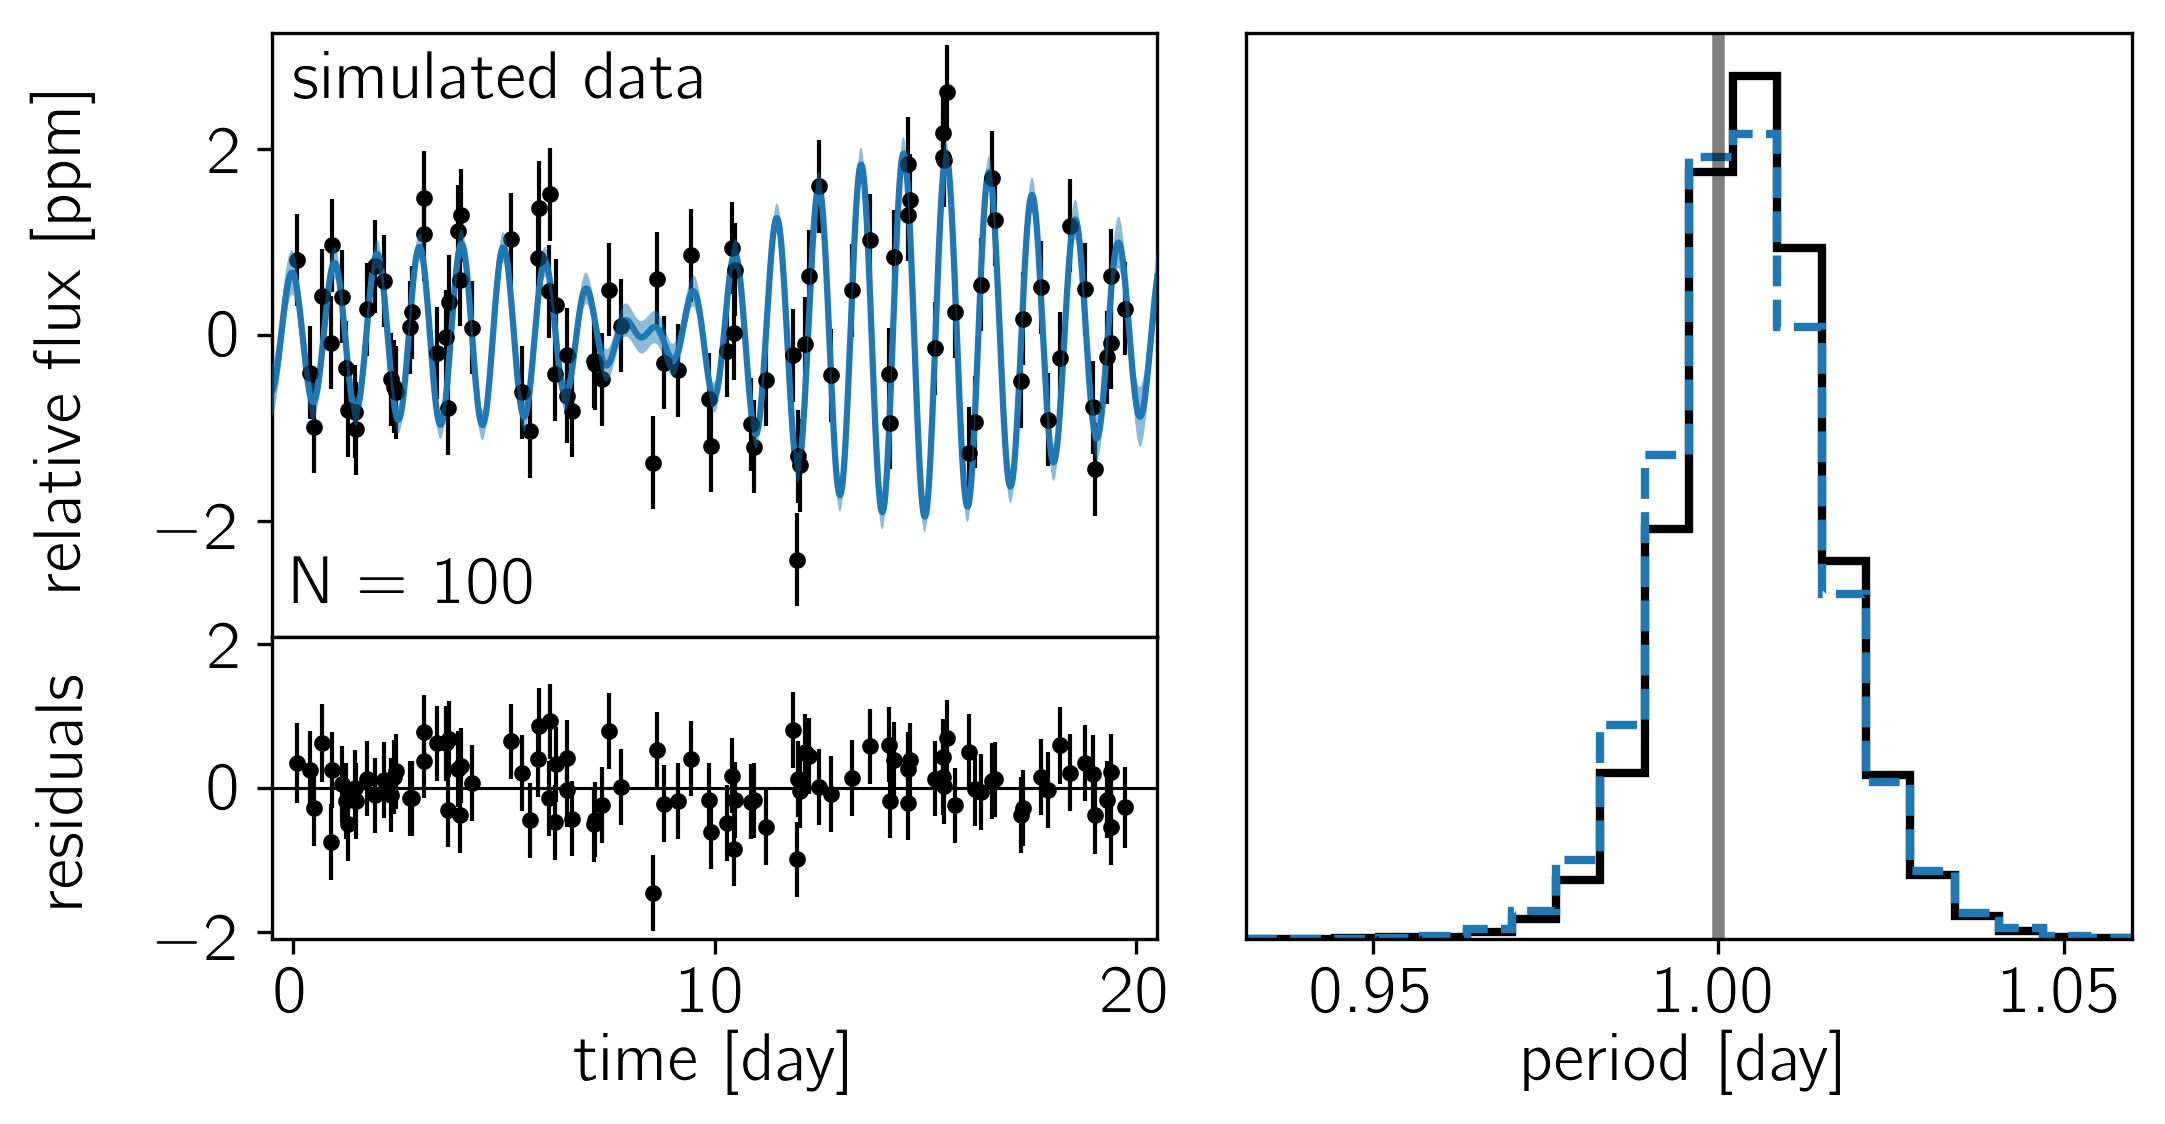

In [22]:
x = np.linspace(-0.5, 20.5, 1000)
mu, var = ml_gp.predict(y, x, return_var=True)
std = np.sqrt(var)

fig = plt.figure(figsize=plot_setup.get_figsize(1, 2))

ax1 = plt.subplot2grid((3, 2), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 2), (2, 0), rowspan=1)
ax3 = plt.subplot2grid((3, 2), (0, 1), rowspan=3)
fig.subplots_adjust(hspace=0, wspace=0.1)

ax1.errorbar(t, y, yerr=yerr, fmt=".k", lw=1)
ax1.plot(x, mu)
ax1.fill_between(x, mu+std, mu-std, alpha=0.5, edgecolor="none", zorder=100)
ax1.set_xticklabels([])

ax1.annotate("simulated data", xy=(0, 1), xycoords="axes fraction",
             xytext=(5, -5), textcoords="offset points",
             ha="left", va="top")
ax1.annotate("N = {0}".format(len(t)), xy=(0, 0),
             xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom")

pred_mu, pred_var = ml_gp.predict(y, return_var=True)
std = np.sqrt(yerr**2 + pred_var)
ax2.errorbar(t, y - pred_mu, yerr=std, fmt=".k", lw=1)
ax2.axhline(0.0, color="k", lw=0.75)

ax1.set_ylim(-3.25, 3.25)
ax1.set_xlim(-0.5, 20.5)
ax2.set_ylim(-2.1, 2.1)
ax2.set_xlim(-0.5, 20.5)

ax2.set_xlabel("time [day]")
ax1.set_ylabel("relative flux [ppm]")
ax2.set_ylabel("residuals")

for ax in [ax1, ax2]:
    ax.yaxis.set_label_coords(-0.2, 0.5)

n, b, p = ax3.hist(np.exp(-sampler.flatchain[:, -2])*(2*np.pi), 20,
                   color="k", histtype="step", lw=2, normed=True)
ax3.hist(np.exp(true_sampler.flatchain[:, -1]), b,
         color=plot_setup.COLORS["MODEL_1"],
         lw=2, histtype="step", normed=True, ls="dashed")
ax3.yaxis.set_major_locator(plt.NullLocator())
ax3.set_xlim(b.min(), b.max())
ax3.axvline(1.0, color="k", lw=3, alpha=0.5)
ax3.set_xlabel("period [day]")

ax2.xaxis.set_label_coords(0.5, -0.3)
ax3.xaxis.set_label_coords(0.5, -0.1)

fig.savefig("wrong-qpo.pdf", bbox_inches="tight")